## **Question 3**

In [1]:
#Read dataset and convert to dataframe
import scipy.io, pandas as pd
mat = scipy.io.loadmat('dataset_1.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}
data = pd.DataFrame()
data['x'], data['y'], data['labels'] = mat['samples'].T[0], mat['samples'].T[1], mat['labels'][0]

**(1) Visualize the (whole dataset) and state your observations.**

It is clear from the below visualization that even though all the three classes overlap a little, they are broadly separable. The whole dataset as been visualized in the below graph.

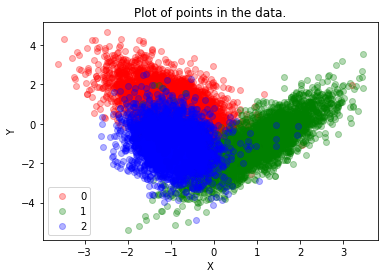

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(data[data.labels == 0]['x'], data[data.labels == 0]['y'], color = 'red', alpha = 0.3)
plt.scatter(data[data.labels == 1]['x'], data[data.labels == 1]['y'], color = 'green', alpha = 0.3)
plt.scatter(data[data.labels == 2]['x'], data[data.labels == 2]['y'], color = 'blue', alpha = 0.3)
plt.legend([0, 1, 2])
plt.title("Plot of points in the data.")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
#Generic function to split data into k folds
from random import randrange
def kSplits(folds, data):
    splits, copy, size = [], list(data.to_numpy()), len(data)//folds
    for i in range(folds):
        fold = []
        while len(fold) < size:
            fold.append(copy.pop(randrange(len(copy))))
        splits.append(fold)
    return np.array(splits)

In [4]:
data = data.sample(frac= 1)

In [5]:
#Splitting dataset into folds
splits = kSplits(5, data)

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
import math

In [8]:
#creating the SVM Class
class SVM:
    def __init__(self, c = 1, decision_function = 'rbf', multi_class = None):    
        self.C = c
        self.clf = SVC()
        self.multi_class = multi_class
    
    def proba(self, X_test):
        k = self.rbf(X_test)
        return (np.array([((self.coeff @ i)+self.inter) for i in k]))
    
    def predict(self, X_test) :  

        if self.multi_class is None:
            return np.sign(self.proba(X_test))
        
        elif self.multi_class =='ovr':
            c_list = []
            probabilities_test = []
            for c, p in self.models:
                probabilities_test.append(p.predict(X_test))
                c_list.append(c)
            probabilities_test = np.array(probabilities_test).squeeze().T
            final_test =[]
            for f in probabilities_test:
                final_test.append(c_list[np.argmax(f)])
            final_test = np.array(final_test)
            return final_test
        
        elif self.multi_class == 'ovo':
            c_list = []
            p_test = []
            for c, p in self.models:
                p_test.append(p.predict(X_test))
                c_list.append(c)
            p_test = np.array(p_test).T
            final_test = []
            for e in p_test:
                temp = []
                for q in range(len(e)):
                    temp.append(c_list[int(q)][int(e[q])])
                temp = np.array(temp)
                final_test.append(np.bincount(temp.astype(int)).argmax())
            final_test = np.array(final_test)
            return final_test
        
        else:
            print("Invalid")
            return 0
        
    def fit(self, x, y) : 
        if self.multi_class == None:
            print("fit done")
            self.clf.fit(x, y.ravel())
            print("fit done")
            self.coeff = self.clf.dual_coef_
            self.inter = self.clf.intercept_
            self.X2 = x[self.clf.support_]
            self.sigma = 1/x[0].size 

        elif self.multi_class  == 'ovr':
            self.fit_ovr(x, y)
        elif self.multi_class == 'ovo':
            self.fit_ovo(x, y)
        else:
            print("Invalid")
            return
    
    def fit_ovr(self, x_train, y_train):
        models = []
        datasets = self.ovr(y_train)
        for u, k in datasets:
            k = k.reshape(-1, 1)
            model = SVC(C =self.C)
            model.fit(x_train, k.ravel())
            models.append((u, model))
        self.models = models
            
    def fit_ovo(self, x_train, y_train):
        models = []
        datasets = self.ovo(y_train)
        for u, k in datasets:
            k = k.reshape(-1, 1)
            model = SVC(C =self.C)
            concat = np.concatenate([x_train, k], axis = 1)
            concat = concat[concat[:, -1]!=-1]
            model.fit(concat[:, :-1], concat[:, -1])
            models.append((u, model))
        self.models = models
        
    def rbf(self, X1):
        k = np.zeros((X1.shape[0], self.X2.shape[0]))
        i=0
        for x1 in X1:
            j=0
            x1 = x1.ravel()
            for x2 in self.X2:
                x2 = x2.ravel()
                k[i,j] = np.exp(-np.sum((x1-x2)@(x1-x2))/(2*(self.sigma**2)))
                j+=1
            i+=1
        return k

    def ovr(self, y):
        classes = np.unique(y)
        n = len(classes)
        datasets = []
        for i in range(n):
            datasets.append((classes[i], np.where(y == classes[i], 1, 0)))
        return datasets
    
    def ovo(self, y):
        classes = np.unique(y)
        n = len(classes) 
        datasets = []
        for i in range(n):
            for j in range(i+1, n):
                datasets.append(((classes[i], classes[j]), np.where(y == classes[i], 0, (np.where(y == classes[j], 1, -1)))))
        return datasets

In [9]:
# import warnings
# warnings.filterwarnings('error')

**(2) Use a SVM with RBF kernel to classify this dataset through one vs rest approach.
Perform the grid search for parameters C and to obtain their optimal values (only on
1 fold). Report the accuracy over the five folds along with the mean accuracy. Also,
report the mean class accuracy.**

For the purpose of performing grid search, the inbuilt implementation has not been used. For the purpose of GS, we perform a 2 level grid search. In this first level, we iterate over a set of values of C (**[0.1, 1, 5, 10, 50, 100, 150]**) to find the optimal value. Once, we get this optimal value (say OPTIM), we next choose values between **[max(OPTIM - 20,  0), OPTIM + 20]**, in intervals of 5, and check for optimal values from this.

In [10]:
#Performing grid search
OPTIMAL_ACC, OPTIMAL_C_ovr = -1, -1
for c_ in [0.1, 1, 5, 10, 50, 100, 150]:
    for i in range(1):
        test = splits[i]
        train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
        temp = []
        for k in train:
            temp.extend(k)
        train = np.array(temp)
        x_train, y_train = train.T[:-1].T, train.T[-1]
        x_test,  y_test = test.T[:-1].T, test.T[-1]
        svc = SVM(c = c_, multi_class = 'ovr')
        svc.fit(x_train, y_train)
        y_pred_test = svc.predict(x_test)
        y_pred_train = svc.predict(x_train)
        acc = accuracy_score(y_test, y_pred_test)
        if acc>OPTIMAL_ACC: OPTIMAL_ACC, OPTIMAL_C_ovr  = acc, c_
        print("Validation accuracy for C =", c_, "is", acc)
        print("Training accuracy for C =", c_, "is", accuracy_score(y_train, y_pred_train))
        print()

print("First Optimal C is", OPTIMAL_C_ovr)

Validation accuracy for C = 0.1 is 0.8695
Training accuracy for C = 0.1 is 0.87375

Validation accuracy for C = 1 is 0.8695
Training accuracy for C = 1 is 0.87425

Validation accuracy for C = 5 is 0.87
Training accuracy for C = 5 is 0.875375

Validation accuracy for C = 10 is 0.871
Training accuracy for C = 10 is 0.87575

Validation accuracy for C = 50 is 0.8705
Training accuracy for C = 50 is 0.87625

Validation accuracy for C = 100 is 0.8705
Training accuracy for C = 100 is 0.8765

Validation accuracy for C = 150 is 0.8705
Training accuracy for C = 150 is 0.877

First Optimal C is 10


In [11]:
#Performing grid search
OPTIMAL_ACC, OPTIMAL_C_ovr_final = -1, -1
for c_ in np.array(list(filter(lambda x: x>0, np.arange(OPTIMAL_C_ovr-20,OPTIMAL_C_ovr+20,5)))):
    for i in range(1):
        test = splits[i]
        train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
        temp = []
        for k in train:
            temp.extend(k)
        train = np.array(temp)
        x_train, y_train = train.T[:-1].T, train.T[-1]
        x_test,  y_test = test.T[:-1].T, test.T[-1]
        svc = SVM(c = c_, multi_class = 'ovr')
        svc.fit(x_train, y_train)
        y_pred_test = svc.predict(x_test)
        y_pred_train = svc.predict(x_train)
        acc = accuracy_score(y_test, y_pred_test)
        if acc>OPTIMAL_ACC: OPTIMAL_ACC, OPTIMAL_C_ovr_final  = acc, c_
        print("Validation accuracy for C =", c_, "is", acc)
        print("Training accuracy for C =", c_, "is", accuracy_score(y_train, y_pred_train))
        print()

print("Final Optimal C is", OPTIMAL_C_ovr_final)

Validation accuracy for C = 5 is 0.87
Training accuracy for C = 5 is 0.875375

Validation accuracy for C = 10 is 0.871
Training accuracy for C = 10 is 0.87575

Validation accuracy for C = 15 is 0.871
Training accuracy for C = 15 is 0.87575

Validation accuracy for C = 20 is 0.871
Training accuracy for C = 20 is 0.875875

Validation accuracy for C = 25 is 0.8705
Training accuracy for C = 25 is 0.87625

Final Optimal C is 10


In [12]:
overall_acc, classes = [], {j : [] for j in np.unique(splits[0][:,-1])}
for i in range(len(splits)):
    print("Fold", i)
    test = splits[i]
    train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
    temp = []
    for k in train:
        temp.extend(k)
    train = np.array(temp)
    x_train, y_train = train.T[:-1].T, train.T[-1]
    x_test,  y_test = test.T[:-1].T, test.T[-1]
    svc = SVM(c = OPTIMAL_C_ovr_final, multi_class = 'ovr')
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    
    unique = list(classes.keys())
    
    matrix = confusion_matrix(y_test, y_pred,  labels= unique)
    accs = matrix.diagonal()/matrix.sum(axis=1)
    for h in range(len(accs)):
        print("Accuracy for class", unique[h],"is",accs[h])
        classes[unique[h]].append(accs[h])
        
    fold_acc = accuracy_score(y_test, y_pred)
    overall_acc.append(fold_acc)
    
    print("Overall Accuracy for fold", i, "is", fold_acc)
    print()

Fold 0
Accuracy for class 0.0 is 0.8830963665086888
Accuracy for class 1.0 is 0.9364341085271318
Accuracy for class 2.0 is 0.8019390581717452
Overall Accuracy for fold 0 is 0.871

Fold 1
Accuracy for class 0.0 is 0.8892261001517451
Accuracy for class 1.0 is 0.9551569506726457
Accuracy for class 2.0 is 0.7872023809523809
Overall Accuracy for fold 1 is 0.877

Fold 2
Accuracy for class 0.0 is 0.8458083832335329
Accuracy for class 1.0 is 0.9568965517241379
Accuracy for class 2.0 is 0.789308176100629
Overall Accuracy for fold 2 is 0.8665

Fold 3
Accuracy for class 0.0 is 0.8845598845598845
Accuracy for class 1.0 is 0.9479940564635958
Accuracy for class 2.0 is 0.7886435331230284
Overall Accuracy for fold 3 is 0.8755

Fold 4
Accuracy for class 0.0 is 0.8633720930232558
Accuracy for class 1.0 is 0.9414483821263482
Accuracy for class 2.0 is 0.8371040723981901
Overall Accuracy for fold 4 is 0.88



In [13]:
#Mean accuracies
print("Overall mean accuracy is",np.mean(np.array(overall_acc)))
for i in classes.keys():
    print("Mean accuracy for class", i, "is", np.mean(np.array(classes[i])))

Overall mean accuracy is 0.874
Mean accuracy for class 0.0 is 0.8732125654954214
Mean accuracy for class 1.0 is 0.947586009902772
Mean accuracy for class 2.0 is 0.8008394441491946


The overall accuracies and classwise accuracies over 5 folds, and the mean accuracies have also been reported in the above outputs

**(3) Use a SVM with RBF kernel to classify this dataset through one vs one approach.
Perform the grid search for parameters C and to obtain their optimal values (only on
1 fold). Report the accuracy over the five folds along with the mean accuracy. Also,
report the mean class accuracy.**

In [14]:
#Performing grid search
OPTIMAL_ACC, OPTIMAL_C_ono = -1, -1
for c_ in [0.1, 1, 5, 10, 50, 100, 150]:
    for i in range(1):
        test = splits[i]
        train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
        temp = []
        for k in train:
            temp.extend(k)
        train = np.array(temp)
        x_train, y_train = train.T[:-1].T, train.T[-1]
        x_test,  y_test = test.T[:-1].T, test.T[-1]
        svc = SVM(c = c_, multi_class = 'ovo')
        svc.fit(x_train, y_train)
        y_pred_test = svc.predict(x_test)
        y_pred_train = svc.predict(x_train)
        acc = accuracy_score(y_test, y_pred_test)
        if acc>OPTIMAL_ACC: OPTIMAL_ACC, OPTIMAL_C_ono  = acc, c_
        print("Validation accuracy for C =", c_, "is", acc)
        print("Training accuracy for C =", c_, "is", accuracy_score(y_train, y_pred_train))
        print()

print("First Optimal C is", OPTIMAL_C_ono)

Validation accuracy for C = 0.1 is 0.873
Training accuracy for C = 0.1 is 0.87725

Validation accuracy for C = 1 is 0.8715
Training accuracy for C = 1 is 0.876625

Validation accuracy for C = 5 is 0.872
Training accuracy for C = 5 is 0.877

Validation accuracy for C = 10 is 0.872
Training accuracy for C = 10 is 0.87675

Validation accuracy for C = 50 is 0.8715
Training accuracy for C = 50 is 0.877

Validation accuracy for C = 100 is 0.8715
Training accuracy for C = 100 is 0.8765

Validation accuracy for C = 150 is 0.8715
Training accuracy for C = 150 is 0.87675

First Optimal C is 0.1


In [15]:
#Performing grid search
OPTIMAL_ACC, OPTIMAL_C_ovo_final = -1, -1
for c_ in np.array(list(filter(lambda x: x>0, np.arange(OPTIMAL_C_ovr-20,OPTIMAL_C_ovr+20,5)))):
    for i in range(1):
        test = splits[i]
        train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
        temp = []
        for k in train:
            temp.extend(k)
        train = np.array(temp)
        x_train, y_train = train.T[:-1].T, train.T[-1]
        x_test,  y_test = test.T[:-1].T, test.T[-1]
        svc = SVM(c = c_, multi_class = 'ovr')
        svc.fit(x_train, y_train)
        y_pred_test = svc.predict(x_test)
        y_pred_train = svc.predict(x_train)
        acc = accuracy_score(y_test, y_pred_test)
        if acc>OPTIMAL_ACC: OPTIMAL_ACC, OPTIMAL_C_ovo_final  = acc, c_
        print("Validation accuracy for C =", c_, "is", acc)
        print("Training accuracy for C =", c_, "is", accuracy_score(y_train, y_pred_train))
        print()

print("Final Optimal C is", OPTIMAL_C_ovo_final)

Validation accuracy for C = 5 is 0.87
Training accuracy for C = 5 is 0.875375

Validation accuracy for C = 10 is 0.871
Training accuracy for C = 10 is 0.87575

Validation accuracy for C = 15 is 0.871
Training accuracy for C = 15 is 0.87575

Validation accuracy for C = 20 is 0.871
Training accuracy for C = 20 is 0.875875

Validation accuracy for C = 25 is 0.8705
Training accuracy for C = 25 is 0.87625

Final Optimal C is 10


In [16]:
overall_acc, classes = [], {j : [] for j in np.unique(splits[0][:,-1])}
for i in range(len(splits)):
    print("Fold", i)
    test = splits[i]
    train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
    temp = []
    for k in train:
        temp.extend(k)
    train = np.array(temp)
    x_train, y_train = train.T[:-1].T, train.T[-1]
    x_test,  y_test = test.T[:-1].T, test.T[-1]
    svc = SVM(c = OPTIMAL_C_ovo_final, multi_class = 'ovo')
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    
    unique = list(classes.keys())
    
    matrix = confusion_matrix(y_test, y_pred,  labels= unique)
    accs = matrix.diagonal()/matrix.sum(axis=1)
    for h in range(len(accs)):
        print("Accuracy for class", unique[h],"is",accs[h])
        classes[unique[h]].append(accs[h])
        
    fold_acc = accuracy_score(y_test, y_pred)
    overall_acc.append(fold_acc)
    
    print("Overall Accuracy for fold", i, "is", fold_acc)
    print()

Fold 0
Accuracy for class 0.0 is 0.8688783570300158
Accuracy for class 1.0 is 0.9457364341085271
Accuracy for class 2.0 is 0.8088642659279779
Overall Accuracy for fold 0 is 0.872

Fold 1
Accuracy for class 0.0 is 0.8786039453717754
Accuracy for class 1.0 is 0.9596412556053812
Accuracy for class 2.0 is 0.7961309523809523
Overall Accuracy for fold 1 is 0.878

Fold 2
Accuracy for class 0.0 is 0.8338323353293413
Accuracy for class 1.0 is 0.9655172413793104
Accuracy for class 2.0 is 0.7971698113207547
Overall Accuracy for fold 2 is 0.868

Fold 3
Accuracy for class 0.0 is 0.8787878787878788
Accuracy for class 1.0 is 0.950965824665676
Accuracy for class 2.0 is 0.7981072555205048
Overall Accuracy for fold 3 is 0.8775

Fold 4
Accuracy for class 0.0 is 0.8473837209302325
Accuracy for class 1.0 is 0.9445300462249615
Accuracy for class 2.0 is 0.8371040723981901
Overall Accuracy for fold 4 is 0.8755



In [17]:
#Mean accuracies
print("Overall mean accuracy is",np.mean(np.array(overall_acc)))
for i in classes.keys():
    print("Mean accuracy for class", i, "is", np.mean(np.array(classes[i])))

Overall mean accuracy is 0.8741999999999999
Mean accuracy for class 0.0 is 0.8614972474898488
Mean accuracy for class 1.0 is 0.9532781603967713
Mean accuracy for class 2.0 is 0.8074752715096759


**(4) For the optimal values of the parameters obtained in (2) and (3), use the sklearn to
make the predictions on the test set. Is there any deviation in the performance?**

There is no deviation in the performance between the custom and inbuilt implementations for both OVR and OVO. The values are almost in the same range.

In [18]:
from sklearn.multiclass import OneVsRestClassifier
overall_acc, classes = [], {j : [] for j in np.unique(splits[0][:,-1])}
for i in range(len(splits)):
    print("Fold", i)
    test = splits[i]
    train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
    temp = []
    for k in train:
        temp.extend(k)
    train = np.array(temp)
    x_train, y_train = train.T[:-1].T, train.T[-1]
    x_test,  y_test = test.T[:-1].T, test.T[-1]
    model = OneVsRestClassifier(SVC(C = OPTIMAL_C_ovr_final)).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    unique = list(classes.keys())
    
    matrix = confusion_matrix(y_test, y_pred,  labels= unique)
    accs = matrix.diagonal()/matrix.sum(axis=1)
    for h in range(len(accs)):
        print("Accuracy for class", unique[h],"is",accs[h])
        classes[unique[h]].append(accs[h])
        
    fold_acc = accuracy_score(y_test, y_pred)
    overall_acc.append(fold_acc)
    
    print("Overall Accuracy for fold", i, "is", fold_acc)
    print()

#Mean accuracies
print("Overall mean accuracy is",np.mean(np.array(overall_acc)))
for i in classes.keys():
    print("Mean accuracy for class", i, "is", np.mean(np.array(classes[i])))

Fold 0
Accuracy for class 0.0 is 0.8688783570300158
Accuracy for class 1.0 is 0.9457364341085271
Accuracy for class 2.0 is 0.8157894736842105
Overall Accuracy for fold 0 is 0.8745

Fold 1
Accuracy for class 0.0 is 0.8770864946889226
Accuracy for class 1.0 is 0.9611360239162929
Accuracy for class 2.0 is 0.8005952380952381
Overall Accuracy for fold 1 is 0.8795

Fold 2
Accuracy for class 0.0 is 0.8308383233532934
Accuracy for class 1.0 is 0.9640804597701149
Accuracy for class 2.0 is 0.800314465408805
Overall Accuracy for fold 2 is 0.8675

Fold 3
Accuracy for class 0.0 is 0.8759018759018758
Accuracy for class 1.0 is 0.950965824665676
Accuracy for class 2.0 is 0.804416403785489
Overall Accuracy for fold 3 is 0.8785

Fold 4
Accuracy for class 0.0 is 0.8430232558139535
Accuracy for class 1.0 is 0.9429892141756548
Accuracy for class 2.0 is 0.8461538461538461
Overall Accuracy for fold 4 is 0.8765

Overall mean accuracy is 0.8753
Mean accuracy for class 0.0 is 0.8591456613576123
Mean accuracy fo

In [19]:
from sklearn.multiclass import OneVsOneClassifier
overall_acc, classes = [], {j : [] for j in np.unique(splits[0][:,-1])}
for i in range(len(splits)):
    print("Fold", i)
    test = splits[i]
    train = np.concatenate([splits[:i],splits[i+1:]], axis = 0)
    temp = []
    for k in train:
        temp.extend(k)
    train = np.array(temp)
    x_train, y_train = train.T[:-1].T, train.T[-1]
    x_test,  y_test = test.T[:-1].T, test.T[-1]
    model = OneVsOneClassifier(SVC(C = OPTIMAL_C_ovo_final)).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    unique = list(classes.keys())
    
    matrix = confusion_matrix(y_test, y_pred,  labels= unique)
    accs = matrix.diagonal()/matrix.sum(axis=1)
    for h in range(len(accs)):
        print("Accuracy for class", unique[h],"is",accs[h])
        classes[unique[h]].append(accs[h])
        
    fold_acc = accuracy_score(y_test, y_pred)
    overall_acc.append(fold_acc)
    
    print("Overall Accuracy for fold", i, "is", fold_acc)
    print()

#Mean accuracies
print("Overall mean accuracy is",np.mean(np.array(overall_acc)))
for i in classes.keys():
    print("Mean accuracy for class", i, "is", np.mean(np.array(classes[i])))

Fold 0
Accuracy for class 0.0 is 0.8688783570300158
Accuracy for class 1.0 is 0.9457364341085271
Accuracy for class 2.0 is 0.8088642659279779
Overall Accuracy for fold 0 is 0.872

Fold 1
Accuracy for class 0.0 is 0.8786039453717754
Accuracy for class 1.0 is 0.9596412556053812
Accuracy for class 2.0 is 0.7961309523809523
Overall Accuracy for fold 1 is 0.878

Fold 2
Accuracy for class 0.0 is 0.8338323353293413
Accuracy for class 1.0 is 0.9655172413793104
Accuracy for class 2.0 is 0.7971698113207547
Overall Accuracy for fold 2 is 0.868

Fold 3
Accuracy for class 0.0 is 0.8787878787878788
Accuracy for class 1.0 is 0.950965824665676
Accuracy for class 2.0 is 0.7981072555205048
Overall Accuracy for fold 3 is 0.8775

Fold 4
Accuracy for class 0.0 is 0.8473837209302325
Accuracy for class 1.0 is 0.9445300462249615
Accuracy for class 2.0 is 0.8371040723981901
Overall Accuracy for fold 4 is 0.8755

Overall mean accuracy is 0.8741999999999999
Mean accuracy for class 0.0 is 0.8614972474898488
Mean 